In [ ]:
!/opt/bin/nvidia-smi

Fri Dec  1 12:42:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import os
from google.colab import drive

# Define transforms with data augmentation for training data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((56, 56)),  # Resize images to 56x56
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomRotation(20),  # Random rotation
        transforms.ToTensor()  # Convert image to PyTorch Tensor data type
    ]),
    'val': transforms.Compose([
        transforms.Resize((56, 56)),  # Resize images to 56x56
        transforms.ToTensor()  # Convert image to PyTorch Tensor data type
    ]),
}

# Mount Google Drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/ODIR5K'

# Load the images from the different directories
dataset = ImageFolder(root_path, transform=data_transforms['train'])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply different transformations to your training and validation sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import models

# Define the number of classes
num_classes = 3  # normal, AMD, pathological myopia

# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Replace the final layer to match the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchvision import models
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Define the model
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # 50% dropout
    nn.Linear(model.fc.in_features, 3)  # output layer for 3 classes
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and the optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)  # L2 regularization

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    accuracies = []
    f1_scores = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0

        # For each batch of training data...
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(inputs)

            # Loss computation
            loss = criterion(outputs, labels)

            # Back propagation
            loss.backward()

            # Parameter update
            optimizer.step()

            # Update loss
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        # Evaluate on the validation data
        model.eval()
        val_preds = []
        val_labels = []

        # For each batch of validation data...
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                # Forward propagation
                outputs = model(inputs)

                # Loss computation
                loss = criterion(outputs, labels)

                # Update loss
                val_loss += loss.item()

                # Get the predicted class with the highest score
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss/len(val_loader))

        # Compute the epoch's accuracy and F1 score
        accuracy = accuracy_score(val_labels, val_preds)
        f1 = f1_score(val_labels, val_preds, average='weighted')

        accuracies.append(accuracy)
        f1_scores.append(f1)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Accuracy: {accuracies[-1]:.4f}, F1 Score: {f1_scores[-1]:.4f}')

    return train_losses, val_losses, accuracies, f1_scores

In [ ]:
train_losses, val_losses, accuracies, f1_scores = train(model, criterion, optimizer, train_loader, val_loader, epochs=60)

Epoch 1/60, Train Loss: 1.2283, Val Loss: 3.1468, Accuracy: 0.4495, F1 Score: 0.3763
Epoch 2/60, Train Loss: 1.1284, Val Loss: 1.0659, Accuracy: 0.4596, F1 Score: 0.3415
Epoch 3/60, Train Loss: 1.0799, Val Loss: 1.0523, Accuracy: 0.4899, F1 Score: 0.3594
Epoch 4/60, Train Loss: 1.1114, Val Loss: 1.6607, Accuracy: 0.4697, F1 Score: 0.3002
Epoch 5/60, Train Loss: 1.0376, Val Loss: 4.5778, Accuracy: 0.4495, F1 Score: 0.3508
Epoch 6/60, Train Loss: 1.0781, Val Loss: 1.0886, Accuracy: 0.4697, F1 Score: 0.3002
Epoch 7/60, Train Loss: 1.0753, Val Loss: 1.0716, Accuracy: 0.4697, F1 Score: 0.3002
Epoch 8/60, Train Loss: 1.0483, Val Loss: 1.0185, Accuracy: 0.5000, F1 Score: 0.3692
Epoch 9/60, Train Loss: 1.0496, Val Loss: 1.0470, Accuracy: 0.4899, F1 Score: 0.3475
Epoch 10/60, Train Loss: 0.9959, Val Loss: 1.0351, Accuracy: 0.4899, F1 Score: 0.3577
Epoch 11/60, Train Loss: 0.9736, Val Loss: 1.1666, Accuracy: 0.4697, F1 Score: 0.3002
Epoch 12/60, Train Loss: 0.9681, Val Loss: 1.0329, Accuracy: 0.

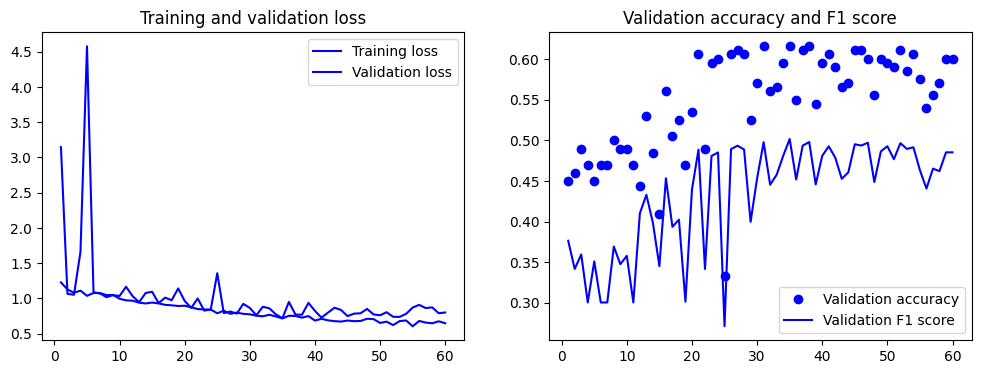

In [ ]:
import matplotlib.pyplot as plt

# Assume we have lists 'train_losses', 'val_losses', 'accuracies', 'f1_scores'
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'bo', label='Validation accuracy')
plt.plot(epochs, f1_scores, 'b', label='Validation F1 score')
plt.title('Validation accuracy and F1 score')
plt.legend()

plt.show()